In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

# data preparation

In [2]:
all_letter = string.ascii_letters + ".,;:'-"
num_letter = len(all_letter) + 1
print(all_letter) # All letters in English.

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;:'-


In [3]:
def findPath(path):
    return glob.glob(path)

def unicode2asc(s):
    return ''.join( c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' and c in all_letter)

def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicode2asc(line) for line in lines]

cate_lines = {}
all_lines = []

try:
    for filename in findPath('data/surnames/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_lines.append(category)
        lines = readLines(filename)
        cate_lines[category] = lines

    num_categories = len(all_lines)
        
except len(num_categories) == 0:
    raise RuntimeError('You should download your data !!!') 

print('# categories:', num_categories, all_lines)
print(unicode2asc("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


# Modeling

In [4]:
class RNN(nn.Module):
    def __init__(self,in_feature,hidden,out_feature):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden
        
        self.i2h = nn.Linear(in_feature + hidden +num_categories,hidden)
        self.i2o = nn.Linear(in_feature + hidden +num_categories,out_feature)
        self.o2o = nn.Linear(hidden+out_feature,out_feature)
        
        self.drop = nn.Dropout(0.1)
    
    def forward(self,x,hidden,category):
        cat_x = torch.cat((x,hidden,category),1)
        hidden = self.i2h(cat_x)
        output = self.i2o(cat_x)
        
        cat_out = torch.cat((hidden,output),1)
        output = F.log_softmax(self.drop(self.o2o(cat_out)),1)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
rnn = RNN(num_letter,128,num_letter)   

# data iteration

In [5]:
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingPair():
    category = randomChoice(all_lines)
    line = randomChoice(cate_lines[category])
    return category, line

In [6]:
##EOS inedx !!!

In [7]:
def cate2Tensor(cate):
    li = all_lines.index(category)
    tensor = torch.zeros(1, num_categories) # shape or we call it size 
    tensor[0][li] = 1
    return tensor

def input2Tensor(line):
    tensor =torch.zeros(len(line),1,num_letter) # 3 Dimensions???
    
    for i in range(len(line)): # EOS would not be input!!
        letter = line[i]
        tensor[i][0][all_letter.find(letter)] = 1 # 1st  location of letter, 2nd we only have 1 dimension here,
        #letter index
    return tensor

def target2Tensor(line):
    letter_indexes = [all_letter.find(line[li]) for li in range(1, len(line))] # 
    letter_indexes.append(num_letter - 1) # EOS,EOS is the last word
    return torch.LongTensor(letter_indexes)


def randomTrainingExample():
    category, line = randomTrainingPair() # seed !
    category_tensor = cate2Tensor(category)
    input_line_tensor = input2Tensor(line)
    target_line_tensor = target2Tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(),lr =0.0001)

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    optimizer.step()
    return output, loss.item() / input_line_tensor.size(0)

In [9]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Trainning 

In [10]:
# 100,000 ~
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 29s (5000 5%) 2.6193
0m 59s (10000 10%) 2.2010
1m 28s (15000 15%) 2.1400
1m 59s (20000 20%) 2.4034
2m 28s (25000 25%) 2.5530
2m 58s (30000 30%) 2.1781
3m 29s (35000 35%) 3.5003
4m 0s (40000 40%) 2.1569
4m 31s (45000 45%) 2.6023
5m 14s (50000 50%) 2.5530
5m 50s (55000 55%) 2.5829
6m 21s (60000 60%) 1.8367
6m 51s (65000 65%) 2.8840
7m 21s (70000 70%) 2.0164
7m 51s (75000 75%) 2.8895
8m 20s (80000 80%) 2.3853
8m 49s (85000 85%) 2.5906
9m 18s (90000 90%) 3.0771
9m 48s (95000 95%) 2.4258
10m 19s (100000 100%) 1.9885


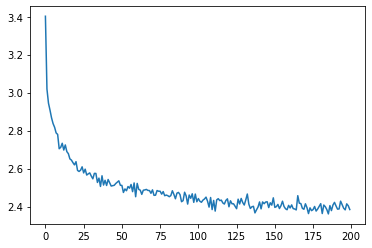

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


In [12]:
max_length = 20
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = cate2Tensor(category)
        input = input2Tensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == num_letter - 1:
                break
            else:
                letter = all_letter[topi]
                output_name += letter
            input = input2Tensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Romer
Urana
Santar
Garesto
Esterra
Rima
Salla
Peren
Alaner
Chang
Honger
Ishiella
